<a href="https://colab.research.google.com/github/lw-miles24/13-CompModNervSys-ExtracellularRec/blob/main/CompModNervSys_exercise13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll be using NEURON for this exercise, so we first install neuron to our runtime.

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Run the code block below just once to get all the files we need from the repository into our colab session and to compile the MOD mechanism files we'll be using.

In [2]:
repo_name = 'CompModNervSys-ExtracellularRec'
if 'google.colab' in str(get_ipython()): # Running on colab
    import os
    # from distutils.dir_util import copy_tree
    if not os.path.exists(repo_name):
        !git clone https://github.com/CompModNervSystem/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir('/content/' + repo_name)

# Compile mechanisms
!nrnivmodl mechanisms

/content/CompModNervSys-ExtracellularRec
Mod files: "mechanisms/mechanisms/CaDynamics_E2.mod" "mechanisms/mechanisms/Ca_HVA.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/Im.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/NaTa_t.mod" "mechanisms/mechanisms/ProbAMPANMDA.mod" "mechanisms/mechanisms/ProbGABAA.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod" "mechanisms/mechanisms/xtra.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Now we can import the packages we'll be using

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if 'google.colab' in str(get_ipython()): # For making interactive plots work on google colab
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    plotly.offline.init_notebook_mode() # for printing notebooks offline

# Simulating the extracellular action potential of a cortical pyramidal neuron

For this exercise, we'll return to the Hay model of a layer 5 pyramidal neuron. For a refresher on the components of this model and how to use it, feel free to revisit [Exercise 10](https://github.com/CompModNervSystem/CompModNervSys-NonLinearDendrites/blob/main/CompModNervSys_exercise10_part1.ipynb).

Briefly, this model uses a reconstructed morphology of the dendritic arbor of an L5 pyramidal cell from rat somatosensory cortex and includes voltage gated sodium, potassium, and calcium channels distributed with different densities in the soma, axon initial segment, apical dendrite, and basal dendrite.Previously, we've restricted ourselves to intracellular recordings, taking advantage of the fact that we can access all model variables with ease, unlike experiments. Combining cable theory with volume conductor theory allows us to simulate an extracellular electrical recording, as is done experimentally.

To do this, we'll make use of the point source approximation for each compartment of the model neuron.

Recall, a point current source $I$ at position $(x_{0},y_{0},z_{0})$ generates an electrical potential $V_{e}$ at a position with coordinates $(x,y,z)$ given by:

$V_{e}(x,y,z) = \frac{I}{4 \pi \sigma_{e} R}$. (1)

Here, $\sigma_e$ is the conductivity of the extracellular space, and $R$ is distance from the recording position $(x,y,z)$ to the recording electrode. We'll use a fixed conductivity approximating gray matter of $0.2 \; S/m$. So, using the equation for distance, we get:

$V_{e}(x,y,z) = \frac{I}{4 \pi \sigma_{e} \sqrt{(x - x_{0})^2 + (y - y_{0})^2 + (z - z_{0})^2}}$. (2)

To calculate the extracellular potential at the point of a recording electrode $(x_e,y_e,z_e)$, we can use the principle of superposition to add up the voltage produced by all $N$ compartments of the model neuron.

$V_{e}(x_{e},y_{e},z_{e}) = \frac{I^{1}_{m}}{4 \pi \sigma_e R_{1}} + \frac{I^{2}_{m}}{4 \pi \sigma_e R_{2}} + ... \frac{I^{N}_{m}}{4 \pi \sigma_e R_{N}} = \sum_{i}^{N} \frac{I_{m}^{i}}{4 \pi \sigma_{e} R_{i}}$. (3)

Here, the superscript notation on $I_{m}$ and subscript on $R$ denote the index of the compartment. Doing this for each time point of our recording allows us to calculate the extracellule voltage signal across time. Finally, we can just as easily do this for multiple neurons to model the signals generated by the surrounding neural populations, which usually would be present in real recordings.

### Building the model

Let's start with building our neuron model and simulating an action potential. For this exercise, we won't worry about incorporating dendritic spines

In [4]:
from helper_functions import createL5PC

morphology_file = "morphologies/cell1.asc" # morphology file
L5PC = createL5PC(morphology_file)

# Create recording vectors for time and somatic voltage, since we know we'll need these later
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(L5PC.soma[0](0.5)._ref_v)


The code below plots the morphology.

In [5]:
ps = h.PlotShape(False) # generate a NEURON PlotShape object
fig = ps.plot(plotly) # Plot using plotly's renderer
scene=dict(camera=dict(up=dict(x=0,y=1,z=0),eye=dict(x=2,y=2,z=2.5)), # define view properties
           xaxis=dict(nticks=3,showticklabels=True),
           yaxis=dict(nticks=3,showticklabels=True),
           zaxis=dict(nticks=3,showticklabels=True),
           aspectmode='data', #this string can be 'data', 'cube', 'auto', 'manual'
           )
fig.update_layout(scene=scene,autosize=False,width=400,height=600)
plotly.io.show(fig)

Now, to calculate the extracellular potential, we'll need the membrane current and position of each compartment (segment). NEURON allows us to record the membrane current density (in $mA/cm^{2}$) from a variable called `i_membrane`, so we'll need to convert this to current density to current ($mA$) by multiplying with the surface area of each compartment. We can access a segment's surface area using the `area` method.

Run the code below to generate the membrane current recording vectors, as well as the coordinates and surface area of each segment.

In [6]:
# Record membrane currents and save surface area of each compartment
i_mems = [] # membrane current density recordings (mA/cm^2)
areas = [] # surface areas (µm^2)
x = [] # x coordinates (µm)
y = [] # y coordinates (µm)
z = [] # z coordinates (µm)
for sec in L5PC.all:
    for seg in sec:
        i_mems.append(h.Vector().record(seg._ref_i_membrane))
        areas.append(seg.area())
        x.append(seg.x_xtra)
        y.append(seg.y_xtra)
        z.append(seg.z_xtra)

areas = np.array(areas)
x = np.array(x)
y = np.array(y)
z = np.array(z)

<font color='red'>1.</font>. Now, insert a current clamp (`h.IClamp`) in the soma and set its amplitude to $1.5 \; nA$, its duration to $5 \; ms$, and delay to $10 \; ms$. The current delivered is then recorded to `stim_current`, so make sure to name your current clamp `stim` (or adjust the name of the recording vector accordingly).

With the stimulation set, run a $50 \; ms$ simulation (`h.tstop`) with an initial voltage (`h.v_init`) of $-77 \; mV$ and temperature (`h.celsius`) of $37^{\circ} C$.

The code below then runs the simulation and plots the membrane voltage vs. time.

In [7]:
# Add a current clamp and name it stim
stim = h.IClamp(0.5,sec = L5PC.soma[0])
stim.dur = 5 # ms
stim.delay = 10 # ms
stim.amp = 1.5 # nA

stim_current = h.Vector().record(stim._ref_i) # record injected current

# Simulation settings
h.celsius = 37 # deg C
h.tstop = 50 # ms
h.v_init = -77 # mV

# Run
h.run()

# Plot
fig = make_subplots()
fig.add_trace(go.Scatter(x=t_vec,y=v_soma,name='Vm'))
fig['layout']['yaxis']['title']='Vm (mV)'
fig['layout']['xaxis']['title']='time (ms)'
fig.show()

You should see a single action potential evoked by by the 5 ms depolarizing current injection. Because of the additional potassium and calcium channels, the afterpotential has additional some complex, slow dynamics that we didn't see with the Hodgkin-Huxley model.

Let's choose a recording electrode location and visualize it. We'll start with an electrode located just outside the neuron, near the soma.

<font color='red'>2.</font> Set `xe` to $100 \; \mu m$, `ye` to $0 \; \mu m$, and `ze` to $0 \; \mu m$ in the code block below to plot.

In [8]:
# choose recording electrode location
xe = 100 # µm
ye = 0 # µm
ze = 0 # µm

# Create dummy section to plot electrode location
elec_location = h.Section(name='elec')
elec_location.pt3dadd(xe,ye,ze,1)


ps = h.PlotShape(False) # generate a NEURON PlotShape object
fig = ps.plot(plotly) # Plot using plotly's renderer
scene=dict(camera=dict(up=dict(x=0,y=1,z=0),eye=dict(x=2,y=2,z=2.5)), # define view properties
           xaxis=dict(nticks=3,showticklabels=True),
           yaxis=dict(nticks=3,showticklabels=True),
           zaxis=dict(nticks=3,showticklabels=True),
           aspectmode='data', #this string can be 'data', 'cube', 'auto', 'manual'
           )
fig.mark(elec_location(0.5))
fig.update_layout(scene=scene,autosize=False,width=400,height=600)
plotly.io.show(fig)

We already ran our simulation, so all we need to is to calculate the extracellular potential $V_{e}$ at our recording electrode location.

The function `calcVe` below implements equation (3) using matrix multiplication, but see the commented code to see how this would be implemented with two for loops. You can check for yourself that these approaches are equivalent by uncommenting that code when we use the function below.

In [9]:
def calcVe(xe,ye,ze,i_mems,x,y,z,areas,Iinj=None,sigma_e = 0.2):
    # Calculate extracellular potential at point electrode for set of compartments
    # Input arguments:
    #   xe - x coordinate of recording electrode (µm)
    #   ye - y coordinate of recording electrode (µm)
    #   ze - z coordinate of recording electrode (µm)
    #   i_mems - list of membrane current density recordings (mA/cm^2)
    #   x - array of x coordinates of recording locations (compartments) (µm)
    #   y - array of y coordinates of recording locations (compartments) (µm)
    #   z - array of z coordinates of recording locations (compartments) (µm)
    #   areas - surface areas of compartments (µm2)
    #   sigma_e - conductivity of extracellular medium (S/m)
    i_mems_arr = [np.array(i) for i in i_mems]
    i_mems_arr = np.array(i_mems_arr).T # convert to number of time points x number of segments matrix
    # multiple each column by corresponding compartment's surface area
    i_mems_arr = i_mems_arr*areas.reshape(1,-1)*1e-8 # mA/cm2 * µm^2 * 1e-8 cm^2/µm2 -> mA
    if Iinj is not None:
        # Subtract injected current from somatic membrane current recording
        i_mems_arr[:,0] = i_mems_arr[:,0] - np.array(Iinj)*1e-6 # converts from nA to mA
    r = np.sqrt((x - xe)**2 + (y- ye)**2 + (z-ze)**2)*1e-6 # distance from recording electrode to all compartments (µm*1e-6 m/µm -> m)

    # Use matrix multiplication to sum Ve from all compartments at each time point (row of i_mems)
    Ve = 1e3*np.matmul(i_mems_arr,1/r)*(1/(4*np.pi*sigma_e)) # mA/(m*S/m) -> mV*1e3 -> µV
    # Equivalent to:
    # Ve = []
    # for ti in range(0,i_mems_arr.shape[0]):
    #     Ve_ti = 0
    #     for n in range(0,i_mems_arr.shape[1]):
    #         Ve_ti += 1e3*i_mems_arr[ti,n]/(4*np.pi*sigma_e*r[n])
    #     Ve.append(Ve_ti)
    # Ve = np.array(Ve)

    return Ve

<font color='red'>3.</font> Below, call `calcVe` and use the code below to plot overlaid the membrane potential ($V_{m}$) and the extracellular potential ($V_{e}$) recorded at your recording electrode location.

In [10]:
# Calculate Ve distribution
Ve = calcVe(xe,ye,ze,i_mems,x,y,z,areas)

# Plot
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=t_vec,y=v_soma,name='Vm'),secondary_y = False)
fig.add_trace(go.Scatter(x=t_vec,y=Ve,name='Ve'),secondary_y = True)
fig.update_layout(yaxis = dict(range=[-80,50]))
# fig.update_layout(yaxis2 = dict(range=[-5,5]))
fig['layout']['yaxis']['title']='Vm (mV)'
fig['layout']['yaxis2']['title']='Ve (uV)'
fig['layout']['xaxis']['title']='time (ms)'
fig.show()

<font color='red'>**Q1**:
Explain what gives rise to the negative and positive phase of the extracellular recording. Why do they have this polarity?
</font>

The extracellular recording near the soma has the opposite polarity as the membrane voltage. This is because of current/flux: when cations flow into the soma during the upsweep of the AP, they're effectively flowing out of the extracellular space. When they flow back out of the soma during the downward phase of the AP, they flow back into the extracellular space, reflected in the plot as a positive change in extracellular voltage.

### How does the signal shape vary as we move along the dendritic tree?

For most real life recordings, we wouldn't know the distance or identity of the neuron we're recording from *a priori*. Using the model, we can explore how the electrode position relative to the neuron's dendritic morphology would alter the signal we record.

<font color='red'>4.</font> Define a vector `ye_vec` of positions for the y-coordinate of the recording electrode containing 5 evenly spaced points from $0$ to $1500 \; \mu m$. The subsequent code plots all these recording electrodes.

In [11]:
# choose recording electrode location
ye_vec = np.linspace(0,1500,5)

# Plot all electrodes
ps = h.PlotShape(False) # generate a NEURON PlotShape object
fig = ps.plot(plotly) # Plot using plotly's renderer
scene=dict(camera=dict(up=dict(x=0,y=1,z=0),eye=dict(x=2,y=2,z=2.5)), # define view properties
           xaxis=dict(nticks=3,showticklabels=True),
           yaxis=dict(nticks=3,showticklabels=True),
           zaxis=dict(nticks=3,showticklabels=True),
           aspectmode='data', #this string can be 'data', 'cube', 'auto', 'manual'
           )
elec_locations = []
for ye in ye_vec:
    elec_location = h.Section(name='elec')
    elec_location.pt3dadd(xe,ye,ze,1)
    fig.mark(elec_location(0.5))
    elec_locations.append(elec_location)

fig.update_layout(scene=scene,autosize=False,width=400,height=600)
plotly.io.show(fig)

<font color='red'>5.</font> Now, use `calcVe` to calculate the extracellular potential at each of these recording locations and plot `Ve` vs. time, either overlaid or on different axes. You may use the plotting package of your choice.

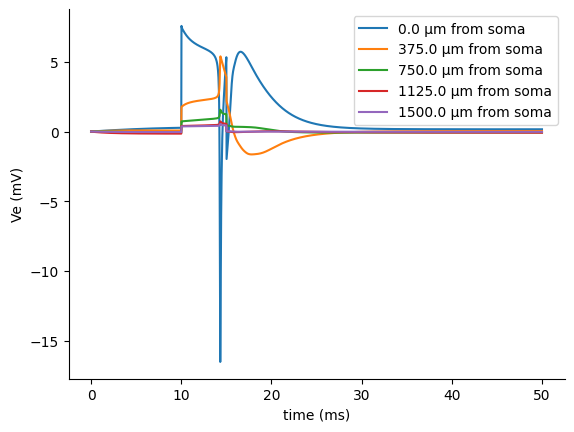

In [12]:
# Loop over ye_vec values
Ve_all = []
for ye in ye_vec:
    Ve_all.append(calcVe(xe,ye,ze,i_mems,x,y,z,areas))

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
for Ve,ye in zip(Ve_all,ye_vec):
    ax.plot(t_vec,Ve,label='{} µm from soma'.format(ye))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Ve (mV)')
ax.legend()

<font color='red'>**Q2**:  What happens to the extracellular action potential signal as you move up the dendritic tree? Why does the polarity flip?
</font>

The polarity of the AP flips with distance because neurons are not single points. A neuron is a closed system, so the injected current must be balanced by other currents; a large influx in the soma means many small effluxes in the arbor. This dipolar property causes the polarity to flip as we move up the tree.

# How does the signal amplitude decay with distance?

Moving along the dendritic tree seems to alter both the shape and magnitude of the signal. While the shape of the signal can tell us about the intracellular voltage dynamics and, to some extent, the location of the electrode relative to the morphology, recording a signal with sufficient amplitude is critical for us to be able to resolve spiking activity from a given neuron. How close do we have to be to do this? During *in vivo* recordings, our electrode picks up signals from our neuron of interest, but also from thermal noise, amplifier noise, environmental noise, and background activity of more distant neurons (neural noise). The electrical potentials from all these noise sources sum with our signal at the recording electrode, which can make extracting the actual signal challenging. Suppose our noise floor (the baseline amount of noise) with our recording system and amplifier is $2 \mu V$ (this is on the low side).

<font color='red'>6.</font> Try varying the x-position (returning `ye` to 0) from $40 \; \mu m$ to $2000 \mu m$ (choose the number of steps as you'd like), and measuring the absolute peak of our extracellular potential signal. Then, plot the absolute peak voltage vs. distance (x-position).

Text(0, 0.5, 'peak Ve (mV)')

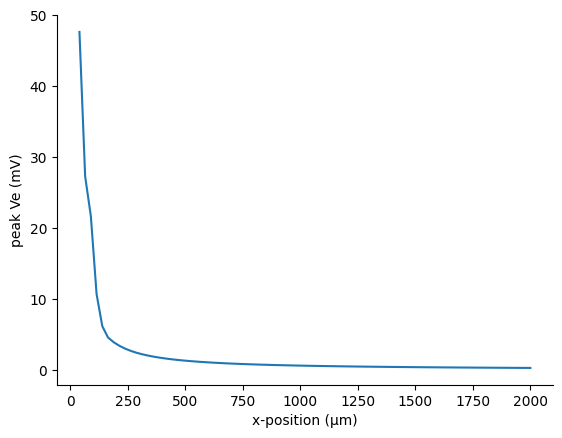

In [22]:
# Loop over x positions
ye = 0
xe_vec = np.linspace(40,2000,80)
# Loop over xe_vec, calculate Ve, then calculate absolute max and append to peak_Ve list
peak_Ve = []
for xe in xe_vec:
    Ve = calcVe(xe,ye,ze,i_mems,x,y,z,areas)
    peak_Ve.append((np.abs(Ve)).max())

# Plot xe_vec vs. peak_Ve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xe_vec,peak_Ve)
ax.set_xlabel('x-position (µm)')
ax.set_ylabel('absolute peak Ve (mV)')

<font color='red'>**Q3**:  How close do you need to be to the neuron to pick up its extracellular action potential above noise?
</font>

Probably within around 100 µm, so that the signal is well above baseline.

<font color='red'>**Bonus Q**:  Try overlaying a $1/r$ and $1/r^{2}$ function (scaled to the same peak) on the same axes. Which function better describes the decay and why?
</font>

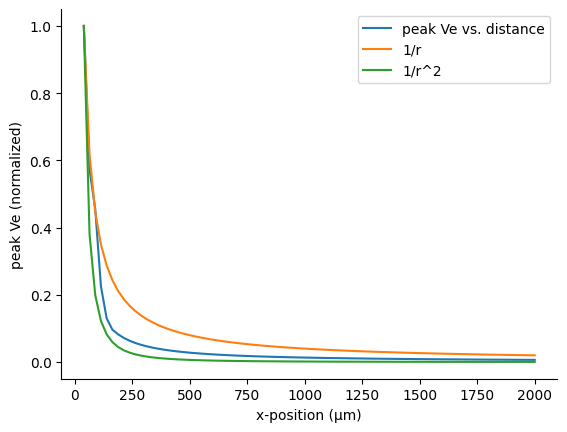

In [27]:
# Plot xe_vec vs. peak_Ve
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(xe_vec,peak_Ve/np.array(peak_Ve).max(),label='peak Ve vs. distance')

ax.plot(xe_vec,(1/xe_vec)/(1/xe_vec).max(),label='1/r')
ax.plot(xe_vec,(1/(xe_vec**2))/(1/(xe_vec**2)).max(),label='1/r^2')

ax.set_xlabel('x-position (µm)')
ax.set_ylabel('peak Ve (normalized)')
ax.legend()

The decay scales best with the monopolar $1/r$ at closer distances, but at farther distances it becomes more influenced by the dipole and scales better with $1/r^2$. (We can even see that inflection point around x = 100 µm, which is cool.)